<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objectif-:" data-toc-modified-id="Objectif-:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objectif :</a></span></li><li><span><a href="#Dev" data-toc-modified-id="Dev-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dev</a></span></li><li><span><a href="#Industrialisation" data-toc-modified-id="Industrialisation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Industrialisation</a></span><ul class="toc-item"><li><span><a href="#Script" data-toc-modified-id="Script-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Script</a></span></li></ul></li><li><span><a href="#Analyse-de-la-feature" data-toc-modified-id="Analyse-de-la-feature-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Analyse de la feature</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np


from vcub_keeper.reader.reader import *
from vcub_keeper.visualisation import plot_station_activity

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Objectif :

- Joindre les données d'activités des stations avec les données météo.
- Industrialisation de la fonction.
- Analyse des résultats.
- [Issue Github](https://github.com/armgilles/vcub_keeper/issues/25)

## Dev

In [2]:
# Lecture de l'activité des stations
ts_activity = read_time_serie_activity(path_directory=ROOT_DATA_CLEAN)

# Lecture des données météo
meteo = read_meteo(path_directory=ROOT_DATA_REF)

In [3]:
ts_activity.shape

(16564512, 8)

In [26]:
ts_activity.head()

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all
0,1,2018-12-01 00:10:00,28.0,4.0,1.0,0.0,0.0,0.0
1,1,2018-12-01 00:20:00,28.0,4.0,1.0,0.0,0.0,0.0
2,1,2018-12-01 00:30:00,28.0,4.0,1.0,0.0,0.0,0.0
3,1,2018-12-01 00:40:00,27.0,5.0,1.0,1.0,0.0,1.0
4,1,2018-12-01 00:50:00,27.0,5.0,1.0,0.0,0.0,0.0


In [27]:
meteo.tail()

,date,temperature,pressure,humidity,precipitation,wind_speed
15787,2020-09-17 19:00:00,26.4,1006.2,39,0.0,1.5
15788,2020-09-17 20:00:00,24.2,1006.3,49,0.0,0.5
15789,2020-09-17 21:00:00,23.9,1006.5,46,0.0,2.6
15790,2020-09-17 22:00:00,24.4,1006.3,45,0.0,3.1
15791,2020-09-17 23:00:00,24.4,1005.9,47,0.0,2.6


In [29]:
# Too long
#ts_activity['date_year_month'] = ts_activity['date'].dt.strftime(date_format='%Y-%m-%d') 
#1min 4s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [30]:
# Faster way
def fast_parse_date_(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    
    cf https://github.com/sanand0/benchmarks/tree/master/date-parse
    """
    dates = {date: date.strftime(format='%Y-%m-%d %H') for date in pd.Series(s.unique())}
    return s.apply(lambda v: dates[v])

ts_activity['date_year_month_hours'] = fast_parse_date_(ts_activity['date'])
# 44.9 s ± 194 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [31]:
meteo['date_year_month_hours'] = fast_parse_date_(meteo['date'])

In [32]:
ts_activity.head()

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,date_year_month_hours
0,1,2018-12-01 00:10:00,28.0,4.0,1.0,0.0,0.0,0.0,2018-12-01 00
1,1,2018-12-01 00:20:00,28.0,4.0,1.0,0.0,0.0,0.0,2018-12-01 00
2,1,2018-12-01 00:30:00,28.0,4.0,1.0,0.0,0.0,0.0,2018-12-01 00
3,1,2018-12-01 00:40:00,27.0,5.0,1.0,1.0,0.0,1.0,2018-12-01 00
4,1,2018-12-01 00:50:00,27.0,5.0,1.0,0.0,0.0,0.0,2018-12-01 00


In [34]:
ts_activity.shape

(16564512, 9)

In [35]:
meteo.head()

,date,temperature,pressure,humidity,precipitation,wind_speed,date_year_month_hours
0,2018-11-30 00:00:00,10.5,1010.5,93,0.000000,6.4,2018-11-30 00
1,2018-11-30 01:00:00,10.3,1010.1,100,0.000000,6.8,2018-11-30 01
2,2018-11-30 02:00:00,10.3,1010.5,100,0.000000,6.8,2018-11-30 02
3,2018-11-30 03:00:00,NaN,1016.4,100,0.575195,6.4,2018-11-30 03
4,2018-11-30 04:00:00,0.0,1009.7,100,0.000000,6.0,2018-11-30 04


In [36]:
ts_activity = ts_activity.merge(meteo.drop('date', axis=1),
                                on='date_year_month_hours', how='left')

In [37]:
ts_activity.sample(8)

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,date_year_month_hours,temperature,pressure,humidity,precipitation,wind_speed
7320003,81,2019-04-15 06:50:00,NaN,NaN,0.0,0.0,0.0,0.0,2019-04-15 06,7.9,1008.9,50,0.0,6.8
3994187,44,2020-07-12 14:00:00,6.0,14.0,1.0,0.0,0.0,0.0,2020-07-12 14,28.4,1014.7,25,0.0,4.4
13601444,149,2020-03-19 21:00:00,9.0,11.0,1.0,0.0,0.0,0.0,2020-03-19 21,12.0,1012.2,78,0.0,8.0
6291569,69,2020-08-23 07:10:00,5.0,9.0,1.0,0.0,0.0,0.0,2020-08-23 07,17.0,1018.9,89,0.0,2.4
7934386,87,2020-07-05 21:00:00,8.0,12.0,1.0,0.0,0.0,0.0,2020-07-05 21,19.6,1016.9,88,0.0,5.2
3978940,44,2020-03-28 16:50:00,0.0,20.0,1.0,0.0,0.0,0.0,2020-03-28 16,17.4,1012.3,35,0.0,4.4
8629538,95,2019-10-15 09:00:00,9.0,7.0,1.0,0.0,0.0,0.0,2019-10-15 09,15.2,1008.9,80,0.0,8.8
9568361,105,2020-03-18 01:10:00,10.0,10.0,1.0,0.0,0.0,0.0,2020-03-18 01,6.9,1024.1,97,0.0,4.0


In [39]:
# Drop useless column
ts_activity = ts_activity.drop('date_year_month_hours', axis=1)

In [40]:
# Check
ts_activity.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16564512 entries, 0 to 16564511
Data columns (total 13 columns):
 #   Column            Non-Null Count     Dtype         
---  ------            --------------     -----         
 0   station_id        16564512 non-null  uint64        
 1   date              16564512 non-null  datetime64[ns]
 2   available_stands  12794673 non-null  float64       
 3   available_bikes   12794673 non-null  float64       
 4   status            16564512 non-null  float64       
 5   transactions_in   16564512 non-null  float64       
 6   transactions_out  16564512 non-null  float64       
 7   transactions_all  16564512 non-null  float64       
 8   temperature       16538580 non-null  float64       
 9   pressure          16559172 non-null  float64       
 10  humidity          16564512 non-null  int64         
 11  precipitation     16564512 non-null  float64       
 12  wind_speed        16564512 non-null  float64       
dtypes: datetime64[ns](1), flo

In [41]:
ts_activity.columns

Index(['station_id', 'date', 'available_stands', 'available_bikes', 'status',
       'transactions_in', 'transactions_out', 'transactions_all',
       'temperature', 'pressure', 'humidity', 'precipitation', 'wind_speed'],
      dtype='object')

## Industrialisation

In [4]:
def get_meteo(data, meteo):
    """
    AJoute les données météo suivantes : 
        - 'temperature' 
        - 'pressure'
        - 'humidity' (%)
       - 'pressure' (mb)
       - 'precipitation' (mm/h)
       - 'wind_speed' (m/s)

    Parameters
    ----------
    data : DataFrame
        Activité des stations Vcub
    meteo : DataFrame
        Données météo

    Returns
    -------
    data : DataFrame
       Ajout des colonnes météo
       
   Examples
   --------
   
   ts_activity = get_meteo(data=ts_activity, meteo=meteo)
   """
   
    def fast_parse_date_(s):
       """
       This is an extremely fast approach to datetime parsing.
       For large data, the same dates are often repeated. Rather than
       re-parse these, we store all unique dates, parse them, and
       use a lookup to convert all dates.

       cf https://github.com/sanand0/benchmarks/tree/master/date-parse
       """
       dates = {date: date.strftime(format='%Y-%m-%d %H') for date in pd.Series(s.unique())}
       return s.apply(lambda v: dates[v])

   
    # Creation des dates au format yyyy_mm avant jointure
    data['date_year_month_hours'] = fast_parse_date_(data['date'])
    meteo['date_year_month_hours'] = fast_parse_date_(meteo['date'])
   
    # Jointure
    data = data.merge(meteo.drop('date', axis=1),
                      on='date_year_month_hours', how='left')
   
    # On supprime la colonne 'date_year_month'
    data = data.drop('date_year_month_hours', axis=1)
    
    return data

In [6]:
# Lecture de l'activité des stations
ts_activity = read_time_serie_activity(path_directory=ROOT_DATA_CLEAN)

# meteo
meteo = read_meteo(path_directory=ROOT_DATA_REF)
ts_activity = get_meteo(data=ts_activity, meteo=meteo)

In [7]:
ts_activity.sample(8)

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,temperature,pressure,humidity,precipitation,wind_speed
7439891,82,2019-10-28 08:20:00,NaN,NaN,0.0,0.0,0.0,0.0,15.6,1011.5,94,0.0,5.2
9667958,106,2020-05-12 04:50:00,12.0,28.0,1.0,0.0,0.0,0.0,8.3,1006.6,89,0.0,6.4
7465749,82,2020-04-24 22:00:00,9.0,11.0,1.0,0.0,0.0,0.0,16.8,1007.0,86,0.0,4.8
2882977,32,2020-04-24 18:20:00,7.0,9.0,1.0,1.0,1.0,2.0,1.0,1005.1,252,0.0,2.0
9994756,110,2019-08-09 15:50:00,17.0,23.0,1.0,0.0,0.0,0.0,25.1,1006.7,47,0.0,4.8
15180301,166,2020-08-10 18:40:00,6.0,14.0,1.0,0.0,0.0,0.0,26.7,1006.7,67,0.0,5.6
879538,10,2020-07-23 20:10:00,15.0,7.0,1.0,0.0,0.0,0.0,21.3,1010.9,71,0.0,6.0
8274075,91,2019-12-31 20:30:00,8.0,8.0,1.0,0.0,0.0,0.0,8.2,1024.4,97,0.0,3.2


### Script

In [1]:
from vcub_keeper.config import *
from vcub_keeper.reader.reader import *
from vcub_keeper.transform.features_factory import get_meteo

In [2]:
# Lecture de l'activité des stations
ts_activity = read_time_serie_activity(path_directory=ROOT_DATA_CLEAN)

# meteo
meteo = read_meteo(path_directory=ROOT_DATA_REF)
ts_activity = get_meteo(data=ts_activity, meteo=meteo)

In [3]:
ts_activity.sample(8)

,station_id,date,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,temperature,pressure,humidity,precipitation,wind_speed
9462482,104,2019-12-10 06:30:00,5.0,12.0,1.0,0.0,0.0,0.0,4.4,1024.6,97,0.0,3.2
13000606,143,2019-04-01 08:20:00,14.0,4.0,1.0,0.0,1.0,1.0,13.7,1009.2,65,0.0,4.0
11599760,127,2020-06-30 03:20:00,20.0,2.0,1.0,0.0,0.0,0.0,13.0,1012.0,87,0.0,2.4
1463356,17,2019-06-18 16:20:00,12.0,2.0,1.0,0.0,0.0,0.0,33.2,1002.4,26,0.0,4.0
6731301,74,2020-04-16 12:40:00,16.0,6.0,1.0,0.0,0.0,0.0,21.6,1009.7,52,0.0,4.8
14408701,158,2019-11-18 09:20:00,8.0,12.0,1.0,0.0,0.0,0.0,5.9,1010.5,88,0.0,3.2
10157399,112,2019-03-19 03:20:00,19.0,21.0,1.0,0.0,0.0,0.0,6.3,1020.8,96,0.0,4.4
1435219,17,2018-12-05 06:50:00,2.0,10.0,1.0,1.0,0.0,1.0,9.2,1015.3,100,0.0,5.2


## Analyse de la feature

In [5]:
# Lecture de l'activité des stations
ts_activity = read_time_serie_activity(path_directory=ROOT_DATA_CLEAN)

# meteo
meteo = read_meteo(path_directory=ROOT_DATA_REF)
ts_activity = get_meteo(data=ts_activity, meteo=meteo)

In [6]:
ts_activity.describe()

,station_id,available_stands,available_bikes,status,transactions_in,transactions_out,transactions_all,temperature,pressure,humidity,precipitation,wind_speed
count,1.656451e+07,1.279467e+07,1.279467e+07,1.656451e+07,1.656451e+07,1.656451e+07,1.656451e+07,1.653858e+07,1.655917e+07,1.656451e+07,1.656451e+07,1.656451e+07
mean,9.171507e+01,1.191106e+01,8.808917e+00,7.519225e-01,1.019004e-01,1.080594e-01,2.037893e-01,1.454256e+01,1.012405e+03,7.611513e+01,1.145145e-01,5.653281e+00
std,5.335660e+01,7.110444e+00,6.105340e+00,4.318970e-01,4.628053e-01,4.775847e-01,6.566652e-01,7.135645e+00,8.232695e+00,2.296710e+01,5.578541e-01,2.489835e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.800000e+00,9.788000e+02,1.500000e+01,0.000000e+00,4.000000e-01
25%,4.600000e+01,7.000000e+00,4.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.400000e+00,1.007900e+03,6.100000e+01,0.000000e+00,4.000000e+00
50%,9.100000e+01,1.100000e+01,8.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.380000e+01,1.012400e+03,8.000000e+01,0.000000e+00,5.600000e+00
75%,1.360000e+02,1.500000e+01,1.200000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.920000e+01,1.017300e+03,9.100000e+01,0.000000e+00,6.800000e+00
max,2.510000e+02,4.400000e+01,4.500000e+01,1.000000e+00,4.300000e+01,8.700000e+01,4.400000e+01,4.040000e+01,1.033200e+03,3.250000e+02,1.300000e+01,2.240000e+01


<AxesSubplot:xlabel='temperature', ylabel='Proportion'>

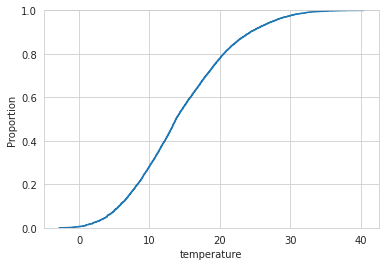

In [7]:
sns.ecdfplot(data=ts_activity, x="temperature")

In [ ]:
# Station les plus active sur les dépôt de vélo
plot_station_activity(ts_activity, station_id=106, features_to_plot=['temperature', 'pressure',
                                                                    'humidity', 'precipitation',
                                                                    'wind_speed'])